In [30]:
from collections import Counter
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Chargement du modèle

model = Word2Vec.load("../models/card2vec.model")

In [3]:
# Chargement des decks

with open("../data/processed/card_corpus.txt", "r", encoding="utf-8") as f:
    deck_lines = f.read().splitlines()
deck_lists = [line.split() for line in deck_lines]
decks = pd.DataFrame({"deck": deck_lists})

In [4]:
# Expression des decks par les embeddings

def deck_vector(deck_list, model):
    """
    Retourne le vecteur moyen d'un deck
    deck_list : liste de cartes
    model : Word2Vec entraîné
    """
    vectors = [model.wv[card] for card in deck_list if card in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Calculer tous les vecteurs de decks
deck_vectors = np.array([deck_vector(d, model) for d in decks["deck"]])

print("Shape des vecteurs de decks :", deck_vectors.shape)

Shape des vecteurs de decks : (20196, 100)


In [17]:
from sklearn.cluster import KMeans

k_zones = 6
km_zone = KMeans(n_clusters=k_zones, random_state=42)
zone_labels = km_zone.fit_predict(deck_vectors)
decks["zone_id"] = zone_labels

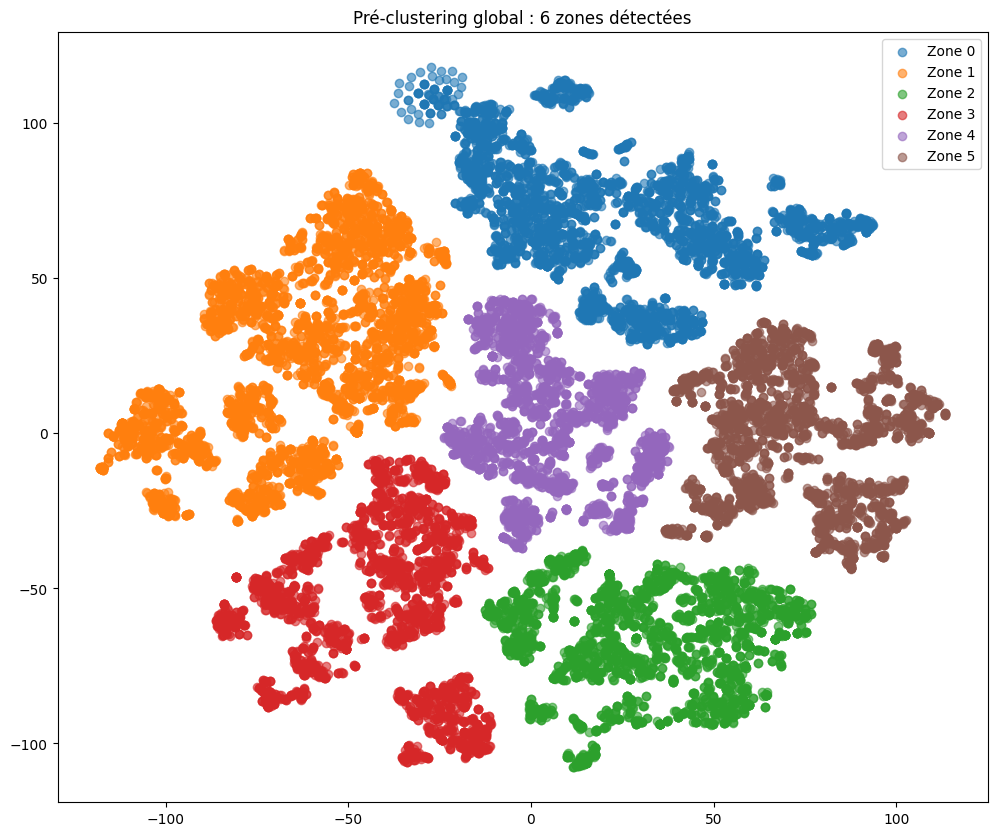

In [19]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
deck_2d = tsne.fit_transform(deck_vectors)

df_plot = pd.DataFrame(deck_2d, columns=["x", "y"])
df_plot["zone_id"] = zone_labels

plt.figure(figsize=(12,10))
for zone in sorted(df_plot["zone_id"].unique()):
    subset = df_plot[df_plot["zone_id"] == zone]
    plt.scatter(subset["x"], subset["y"], label=f"Zone {zone}", alpha=0.6)
plt.legend()
plt.title("Pré-clustering global : 6 zones détectées")
plt.show()

In [24]:
decks["subcluster"] = -1 
max_k = 10 

for zone in sorted(decks["zone_id"].unique()):
    mask = decks["zone_id"] == zone
    vectors_zone = deck_vectors[mask]
    
    best_score = -1
    best_k = 2
    best_labels = None
    
    # Tester k = 2 à max_k
    for k in range(2, max_k+1):
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(vectors_zone)
        score = silhouette_score(vectors_zone, labels)
        
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
    
    # Assignation avec offset pour labels uniques
    offset = zone * 100
    decks.loc[mask, "subcluster"] = best_labels + offset
    
    print(f"Zone {zone} -> meilleur k = {best_k}, silhouette = {best_score:.3f}")

Zone 0 -> meilleur k = 6, silhouette = 0.368
Zone 1 -> meilleur k = 2, silhouette = 0.409
Zone 2 -> meilleur k = 5, silhouette = 0.359
Zone 3 -> meilleur k = 2, silhouette = 0.521
Zone 4 -> meilleur k = 9, silhouette = 0.385
Zone 5 -> meilleur k = 4, silhouette = 0.395


In [25]:
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
deck_3d = tsne.fit_transform(deck_vectors)

df_plot = pd.DataFrame(deck_3d, columns=["x", "y", "z"])
df_plot["subcluster"] = decks["subcluster"]
df_plot["zone_id"] = decks["zone_id"]
df_plot["deck_id"] = decks.index 

In [ ]:
for zone in sorted(df_plot["zone_id"].unique()):
    df_zone = df_plot[df_plot["zone_id"] == zone]
    
    fig = px.scatter_3d(
        df_zone, x="x", y="y", z="z",
        color="subcluster",
        hover_data=["deck_id", "subcluster"],
        title=f"Zone {zone} - Sous-clusters"
    )
    fig.update_traces(marker=dict(size=5, opacity=0.8))
    fig.show()

In [32]:
deck_lists_series = pd.Series(deck_lists)

# Fréquence globale des cartes
global_counter = Counter()
for deck in deck_lists_series:
    global_counter.update(deck)

cluster_summary = {}

for cluster_id in sorted(decks["subcluster"].unique()):
    mask = decks["subcluster"] == cluster_id
    decks_in_cluster = deck_lists_series[mask]
    
    # Fréquence dans le cluster
    counter = Counter()
    for deck in decks_in_cluster:
        counter.update(deck)
    
    # Score combiné : fréquence dans le cluster * spécificité
    combined_score = {card: (counter[card]) * (counter[card] / global_counter[card])
                      for card in counter}
    
    # Top 10 cartes les plus représentatives + spécifiques
    top_cards = sorted(combined_score.items(), key=lambda x: x[1], reverse=True)[:10]
    cluster_summary[cluster_id] = top_cards

# Convertir en DataFrame pour affichage
summary_df = pd.DataFrame({
    "subcluster": list(cluster_summary.keys()),
    "top_cards": [", ".join([f"{card}({score:.1f})" for card, score in cards])
                  for cards in cluster_summary.values()]
})

display(summary_df)

,subcluster,top_cards
0,0,"ALT_CORE_B_OR_30_C(644.9), ALT_CORE_B_OR_23_C(..."
1,1,"ALT_BISE_B_OR_59_C(1533.7), ALT_BISE_B_OR_49_C..."
2,2,"ALT_CORE_B_OR_18_R1(374.7), ALT_CORE_B_OR_22_C..."
3,3,"ALT_BISE_B_OR_62_R1(1071.4), ALT_ALIZE_B_OR_43..."
4,4,"ALT_CYCLONE_B_OR_71_C(549.0), ALT_CYCLONE_B_OR..."
5,5,"ALT_CORE_B_YZ_11_R2(1974.8), ALT_CORE_B_AX_07_..."
6,100,"ALT_CORE_B_YZ_18_R2(1395.9), ALT_ALIZE_B_BR_45..."
7,101,"ALT_ALIZE_B_BR_32_C(8123.9), ALT_ALIZE_B_BR_34..."
8,200,"ALT_CORE_B_MU_06_R1(3311.7), ALT_CORE_B_AX_06_..."
9,201,"ALT_CORE_B_AX_14_R2(844.6), ALT_CORE_B_LY_29_R..."
